# SEQ Task Position Heatmap/Bar Plot 

In [1]:
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('muted')

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

#sids = ['783125', '783126']

sids = ['783125', '783126', '783127', '783128', '783129', '783130', '783131', '783132', '783133', '783134',
        '783135', '783136', '783137', '783138', '783139', '783140', '783141', '783142', '783144', '783146',
        '783147', '783148', '783149', '783150', '783151', '783152', '783153', '783154', '783155', '783156',
        '783157', '783158', '783159', '783163'] #34 subjects

#removed '783143' - no masks
proj_dir = '/home/data/madlab/data/mri/seqtrd' 
mask_filenames = []
cope_files = []
for SID in sids:
    subjmasks = glob(proj_dir + '/mask/cortical_rois/{0}/anat_masks/_subject_id_{0}/*'.format(SID))
    subjmasks.sort()
    mask_filenames.append(subjmasks)
    subjcopes = glob(proj_dir + '/frstlvl/seq_item_pos/*_pos*/' + SID + '/modelfit/contrasts/cope02_*_pos*.nii.gz')
    subjcopes.sort()
    cope_files.append(subjcopes)    
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 17:
        print(SID)

## Cell to double-check the array indexing

In [2]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(mask_filenames[0]):
    print(i, mask_filenames[0][i].split('/')[-1][:-7])

(0, 'cerebellum_bimask_warped')
(1, 'l_ant_hpc_warped')
(2, 'l_cerebellum_bimask_warped')
(3, 'lh-angular-gyrus_fs_warped')
(4, 'lh-caudate_warped')
(5, 'lh-motor_fs_warped')
(6, 'lh-pcc_fs_warped')
(7, 'lh-precuneus_fs_warped')
(8, 'lh-superiortemporalctx_warped')
(9, 'lh_hpc_warped')
(10, 'lh_mpfc_warped')
(11, 'limbicthal_bin_trans_warped')
(12, 'r_ant_hpc_warped')
(13, 'r_cerebellum_bimask_warped')
(14, 'rh-angular-gyrus_fs_warped')
(15, 'rh-caudate_warped')
(16, 'rh-motor_fs_warped')
(17, 'rh-pcc_fs_warped')
(18, 'rh-precuneus_fs_warped')
(19, 'rh-superiortemporalctx_warped')
(20, 'rh_hpc_warped')
(21, 'rh_mpfc_warped')
(22, 'seq_bold_r01_dtype_despike_roi')
(23, 'x_bihemi_ant_hpc_warped')
(24, 'x_bihemi_mpfc_warped')
(25, 'x_combined_antHC_mPFC_mask')


In [3]:
for i, curr_cope in enumerate(cope_files[0]):
    print(i, cope_files[0][i].split('/')[-1][7:-7]) 

(0, 'inseq_pos2')
(1, 'inseq_pos3')
(2, 'inseq_pos4')
(3, 'inseq_pos5')
(4, 'inseq_pos6')
(5, 'ot_pos2')
(6, 'ot_pos3')
(7, 'ot_pos4')
(8, 'ot_pos5')
(9, 'repeat_pos3')
(10, 'repeat_pos4')
(11, 'repeat_pos5')
(12, 'repeat_pos6')
(13, 'skip_pos2')
(14, 'skip_pos3')
(15, 'skip_pos4')
(16, 'skip_pos5')


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [7]:
inseq = {'subjid':[],
         'hp_pos2':[], 'hp_pos3':[], 'hp_pos4':[], 'hp_pos5':[], 'hp_pos6':[],  
         'mpfc_pos2':[], 'mpfc_pos3':[], 'mpfc_pos4':[], 'mpfc_pos5':[], 'mpfc_pos6':[]}

ot = {'subjid':[],
      'hp_pos2':[], 'hp_pos3':[], 'hp_pos4':[], 'hp_pos5':[],  
      'mpfc_pos2':[], 'mpfc_pos3':[], 'mpfc_pos4':[], 'mpfc_pos5':[]}

repeat = {'subjid':[],
          'hp_pos3':[], 'hp_pos4':[], 'hp_pos5':[], 'hp_pos6':[], 
          'mpfc_pos3':[], 'mpfc_pos4':[], 'mpfc_pos5':[], 'mpfc_pos6':[]}

skip = {'subjid':[],
        'hp_pos2':[],'hp_pos3':[], 'hp_pos4':[], 'hp_pos5':[], 
        'mpfc_pos2':[], 'mpfc_pos3':[], 'mpfc_pos4':[], 'mpfc_pos5':[]}
           
          
for i in range(len(sids)):
    inseq['subjid'].append(sids[i])
    ot['subjid'].append(sids[i])
    repeat['subjid'].append(sids[i])
    skip['subjid'].append(sids[i])
    lh_hp_img = nb.load(mask_filenames[i][0])
    rh_hp_img = nb.load(mask_filenames[i][3])
    lh_mpfc_img = nb.load(mask_filenames[i][1])
    rh_mpfc_img = nb.load(mask_filenames[i][4])
    
    inseq_pos2_img = nb.load(cope_files[i][0])
    inseq_pos3_img = nb.load(cope_files[i][1])
    inseq_pos4_img = nb.load(cope_files[i][2])
    inseq_pos5_img = nb.load(cope_files[i][3])
    inseq_pos6_img = nb.load(cope_files[i][4])
    ot_pos2_img = nb.load(cope_files[i][5])
    ot_pos3_img = nb.load(cope_files[i][6])
    ot_pos4_img = nb.load(cope_files[i][7])
    ot_pos5_img = nb.load(cope_files[i][8])
    repeat_pos3_img = nb.load(cope_files[i][9])
    repeat_pos4_img = nb.load(cope_files[i][10])
    repeat_pos5_img = nb.load(cope_files[i][11])
    repeat_pos6_img = nb.load(cope_files[i][12]) 
    skip_pos2_img = nb.load(cope_files[i][13])
    skip_pos3_img = nb.load(cope_files[i][14])
    skip_pos4_img = nb.load(cope_files[i][15])
    skip_pos5_img = nb.load(cope_files[i][16]) 

    pos = ['pos2', 'pos3', 'pos4', 'pos5', 'pos6']
    
    for r in ['hp', 'mpfc']:
        for d in ['inseq', 'ot', 'repeat', 'skip']:      
            if d in ['skip', 'ot']: #if a skip or ot trial
                for p in pos[:-1]: #iterate through pos2-5
                    lh_data = eval('{0}_{1}_img.get_data()[lh_{2}_img.get_data() > 0.]'.format(d,p,r))   
                    rh_data = eval('{0}_{1}_img.get_data()[rh_{2}_img.get_data() > 0.]'.format(d,p,r))
                    bihemi_data = np.concatenate((lh_data, rh_data))
                    eval('{0}["{1}_{2}"].append(bihemi_data)'.format(d,r,p))
            elif d == 'repeat':#if a repeat trial
                for p in pos[1:]: #iterate through pos3-6
                    lh_data = eval('{0}_{1}_img.get_data()[lh_{2}_img.get_data() > 0.]'.format(d,p,r))
                    rh_data = eval('{0}_{1}_img.get_data()[rh_{2}_img.get_data() > 0.]'.format(d,p,r))
                    bihemi_data = np.concatenate((lh_data, rh_data))
                    repeat['{0}_{1}'.format(r,p)].append(bihemi_data) 
            else: #if an inseq trial    
                for p in pos: #iterate through pos2-6
                    lh_data = eval('{0}_{1}_img.get_data()[lh_{2}_img.get_data() > 0.]'.format(d,p,r))
                    rh_data = eval('{0}_{1}_img.get_data()[rh_{2}_img.get_data() > 0.]'.format(d,p,r))
                    bihemi_data = np.concatenate((lh_data, rh_data))
                    inseq['{0}_{1}'.format(r,p)].append(bihemi_data)
                    
inseq_df = pd.DataFrame(inseq) 
ot_df = pd.DataFrame(ot) 
repeat_df = pd.DataFrame(repeat) 
skip_df = pd.DataFrame(skip) 

In [5]:
inseq_hp = {}
inseq_hp['pos3'] = inseq_df['hp_pos3']
inseq_hp['pos4'] = inseq_df['hp_pos4']
inseq_hp['pos5'] = inseq_df['hp_pos5']
inseq_hp_df = pd.DataFrame(inseq_hp)

ot_hp = {}
ot_hp['pos3'] = ot_df['hp_pos3']
ot_hp['pos4'] = ot_df['hp_pos4']
ot_hp['pos5'] = ot_df['hp_pos5']
ot_hp_df = pd.DataFrame(ot_hp)

# HIPPOCAMPUS

In [6]:
HPC_raw_diags = {'ots':[], 'skips':[], 'repeats':[]}
HPC_avg_diags = {'ots':[], 'skips':[], 'repeats':[]}

pos = ['2', '3', '4', '5', '6']

for i, sub in enumerate(sids):
    for d in ['inseq', 'ot', 'repeat', 'skip']:      
        if d in ['skip', 'ot']: #if a skip or ot trial
            for j, p in enumerate(pos[:-1]): #iterate through pos2-5      
                x = eval('stats.pearsonr({0}_df["hp_pos{1}"][{2}],inseq_df["hp_pos{1}"][{2}])[0]'.format(d,pos[j],i))
                eval('HPC_raw_diags["{0}s"].append(x)'.format(d))
        elif d == 'repeat':#if a repeat trial
            for j, p in enumerate(pos[1:]): #iterate through pos3-6
                x = eval('stats.pearsonr(repeat_df["hp_pos{0}"][{1}],inseq_df["hp_pos{0}"][{1}])[0]'.format(pos[j+1],i))
                HPC_raw_diags["repeats"].append(x)

for k in range(0,136,4):
    HPC_avg_diags['ots'].append(np.mean(HPC_raw_diags['ots'][k:k+3]))
    HPC_avg_diags['skips'].append(np.mean(HPC_raw_diags['skips'][k:k+3]))
    HPC_avg_diags['repeats'].append(np.mean(HPC_raw_diags['repeats'][k:k+3]))
    
HPC_avg_df = pd.DataFrame(HPC_avg_diags)

In [8]:
#These are the average diagonals per participant
HPC_avg_df

,ots,repeats,skips
0,0.156873,0.102888,0.149399
1,-0.009673,0.059514,0.093671
2,0.251281,0.191269,0.184006
3,0.526575,0.333276,0.517070
4,0.684876,0.120900,0.587591
5,0.200338,-0.089959,0.083376
6,0.184180,0.383347,0.323538
7,0.099423,0.131357,0.101758
8,0.207379,0.090045,0.029886
9,0.312590,0.464150,0.302402


In [9]:
HPC_avg_df.corr()

,ots,repeats,skips
ots,1.000000,0.580805,0.864022
repeats,0.580805,1.000000,0.751201
skips,0.864022,0.751201,1.000000


In [10]:
HPC_avg_df

,ots,repeats,skips
0,0.156873,0.102888,0.149399
1,-0.009673,0.059514,0.093671
2,0.251281,0.191269,0.184006
3,0.526575,0.333276,0.517070
4,0.684876,0.120900,0.587591
5,0.200338,-0.089959,0.083376
6,0.184180,0.383347,0.323538
7,0.099423,0.131357,0.101758
8,0.207379,0.090045,0.029886
9,0.312590,0.464150,0.302402


In [11]:
print "OTs: ", stats.shapiro(HPC_avg_df['ots'])
print "Repeats: ", stats.shapiro(HPC_avg_df['repeats'])
print "Skips: ", stats.shapiro(HPC_avg_df['skips'])

OTs:  (0.968528687953949, 0.4221110939979553)
Repeats:  (0.9822919368743896, 0.8417723774909973)
Skips:  (0.9555405974388123, 0.17972101271152496)


Mean ots: 0.252001032233
STD ots: 0.183680710155
Shapiro's Test of Normality: (0.968528687953949, 0.4221110939979553)
--------
Mean repeats: 0.258868389106
STD repeats: 0.156048559734
Shapiro's Test of Normality: (0.9822919368743896, 0.8417723774909973)
--------
Mean skips: 0.300054781605
STD skips: 0.19461527642
Shapiro's Test of Normality: (0.9555405974388123, 0.17972101271152496)
--------


/home/data/madlab/envs/hcp_madlab_env/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


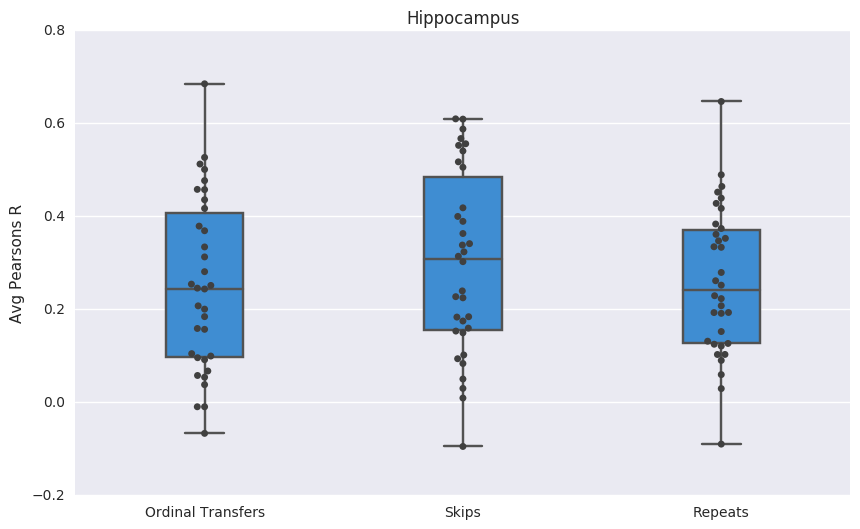

In [12]:
for key in HPC_avg_df:
    print "Mean {0}:".format(key), np.mean(HPC_avg_df['{0}'.format(key)])
    print "STD {0}:".format(key), np.std(HPC_avg_df['{0}'.format(key)])
    print "Shapiro's Test of Normality:", stats.shapiro(HPC_avg_df['{0}'.format(key)])
    print "--------"
    
N = 3
conditions = ['Ordinal Transfers', 'Skips', 'Repeats']
hp_allsubjs = [HPC_avg_df['ots'], HPC_avg_df['skips'], HPC_avg_df['repeats']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,6))
ax0 = sns.boxplot(data = hp_allsubjs, color = "#278fea", width = 0.3)
ax2 = sns.swarmplot(data = hp_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Avg Pearsons R")
ax.set_title("Hippocampus")
plt.show()

### Ordinal Transfers

Mean pos4:  0.350817
STD pos4:  0.222995
Shapiro's Test of Normality: (0.9590137600898743, 0.22755101323127747)
--------
Mean pos5:  0.183263
STD pos5:  0.212759
Shapiro's Test of Normality: (0.9494008421897888, 0.1178155317902565)
--------
Mean pos2:  0.19676
STD pos2:  0.199967
Shapiro's Test of Normality: (0.9748122692108154, 0.6054933667182922)
--------
Mean pos3:  0.208426
STD pos3:  0.229525
Shapiro's Test of Normality: (0.9450898170471191, 0.08749356865882874)
--------


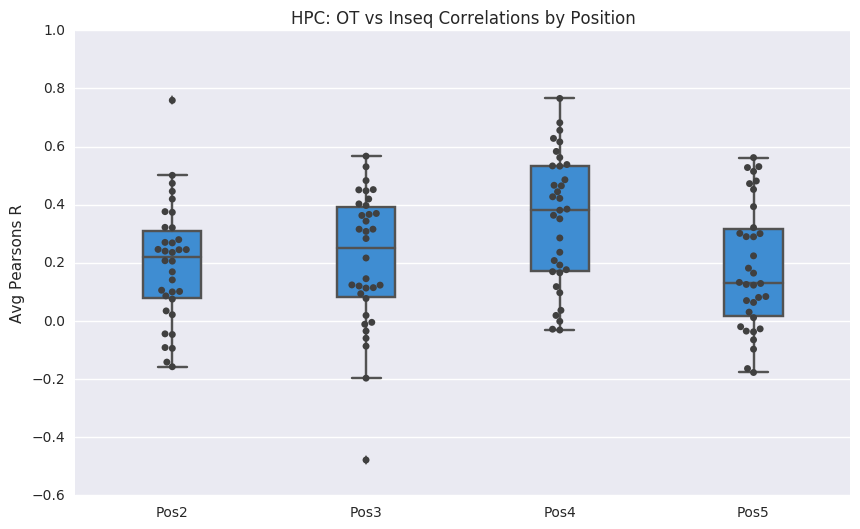

In [13]:
ot_hp_corrs = {'pos2':[], 'pos3':[], 'pos4':[], 'pos5':[]}

for i, sub in enumerate(sids):
    for x in ['2','3','4','5']:
        hp_corr = eval('stats.pearsonr(ot_df["hp_pos{0}"][{1}], inseq_df["hp_pos{0}"][{1}])[0]'.format(x,i))
        ot_hp_corrs["pos{0}".format(x)].append(hp_corr)
ot_hp_corrs_df = pd.DataFrame(ot_hp_corrs)
corr_table = []
for key in ot_hp_corrs:
    print "Mean {0}: ".format(key), np.mean(ot_hp_corrs['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(ot_hp_corrs['{0}'.format(key)])
    print "Shapiro's Test of Normality:", stats.shapiro(ot_hp_corrs['{0}'.format(key)])
    print "--------"
N = 4
conditions = ['Pos2', 'Pos3', 'Pos4', 'Pos5']
hp_allsubjs = [ot_hp_corrs['pos2'], ot_hp_corrs['pos3'], 
               ot_hp_corrs['pos4'], ot_hp_corrs['pos5']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,6))
ax0 = sns.boxplot(data = hp_allsubjs, color = "#278fea", width = 0.3)
ax2 = sns.swarmplot(data = hp_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Avg Pearsons R")
ax.set_title("HPC: OT vs Inseq Correlations by Position")
plt.show()

### Skips

Mean pos4:  0.396729
STD pos4:  0.230081
Shapiro's Test of Normality: (0.9724372625350952, 0.5318148136138916)
--------
Mean pos5:  0.154777
STD pos5:  0.17829
Shapiro's Test of Normality: (0.9687462449073792, 0.42777517437934875)
--------
Mean pos2:  0.258944
STD pos2:  0.158633
Shapiro's Test of Normality: (0.9813665151596069, 0.8147729635238647)
--------
Mean pos3:  0.244491
STD pos3:  0.256253
Shapiro's Test of Normality: (0.9621784687042236, 0.2811279594898224)
--------


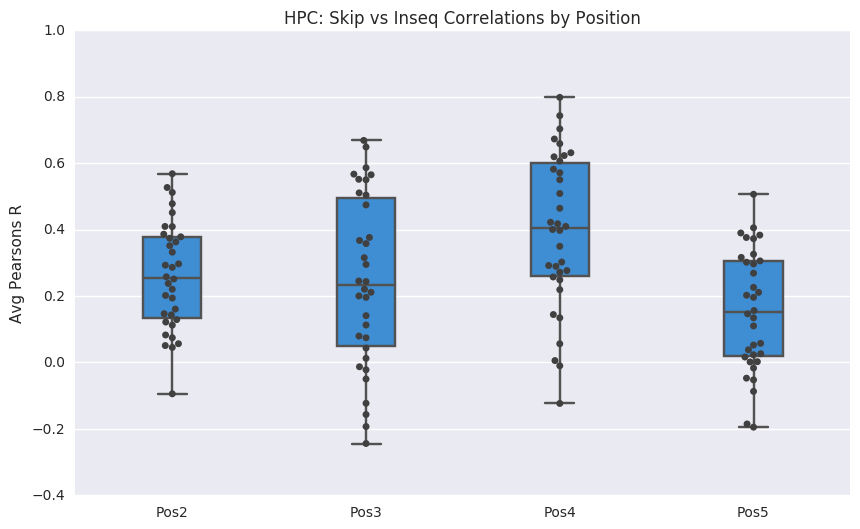

In [14]:
skip_hp_corrs = {'pos2':[], 'pos3':[], 'pos4':[], 'pos5':[]}

for i, sub in enumerate(sids):
    for x in ['2','3','4','5']:
        hp_corr = eval('stats.pearsonr(skip_df["hp_pos{0}"][{1}], inseq_df["hp_pos{0}"][{1}])[0]'.format(x,i))
        skip_hp_corrs["pos{0}".format(x)].append(hp_corr)
skip_hp_corrs_df = pd.DataFrame(skip_hp_corrs)
corr_table = []
for key in skip_hp_corrs:
    print "Mean {0}: ".format(key), np.mean(skip_hp_corrs['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(skip_hp_corrs['{0}'.format(key)])
    print "Shapiro's Test of Normality:", stats.shapiro(skip_hp_corrs['{0}'.format(key)])
    print "--------"
N = 4
conditions = ['Pos2', 'Pos3', 'Pos4', 'Pos5']
hp_skip_allsubjs = [skip_hp_corrs['pos2'], skip_hp_corrs['pos3'], 
                    skip_hp_corrs['pos4'], skip_hp_corrs['pos5']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,6))
ax0 = sns.boxplot(data = hp_skip_allsubjs, color = "#278fea", width = 0.3)
ax2 = sns.swarmplot(data = hp_skip_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Avg Pearsons R")
ax.set_title("HPC: Skip vs Inseq Correlations by Position")
plt.show()

#sns.heatmap(corr_table, annot=True)

### Repeats

Mean pos6:  0.179804
STD pos6:  0.215953
Shapiro's Test of Normality: (0.9794216752052307, 0.7545115351676941)
--------
Mean pos4:  0.354244
STD pos4:  0.207347
Shapiro's Test of Normality: (0.9626418352127075, 0.28985604643821716)
--------
Mean pos5:  0.250795
STD pos5:  0.182757
Shapiro's Test of Normality: (0.9697080254554749, 0.4534651041030884)
--------
Mean pos3:  0.171567
STD pos3:  0.1889
Shapiro's Test of Normality: (0.958644688129425, 0.22195181250572205)
--------


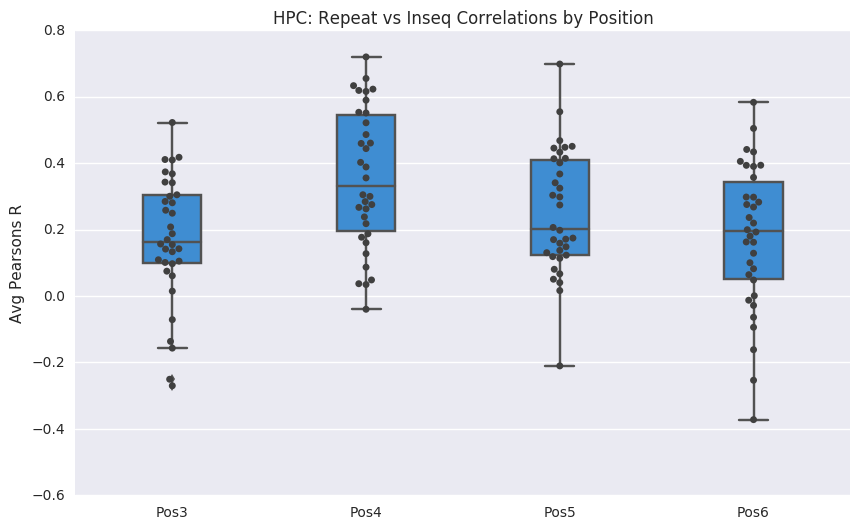

In [15]:
repeat_hp_corrs = {'pos3':[], 'pos4':[], 'pos5':[], 'pos6':[]}

for i, sub in enumerate(sids):
    for x in ['3','4','5','6']:
        hp_corr = eval('stats.pearsonr(repeat_df["hp_pos{0}"][{1}],inseq_df["hp_pos{0}"][{1}])[0]'.format(x,i))
        repeat_hp_corrs["pos{0}".format(x)].append(hp_corr)
repeat_hp_corrs_df = pd.DataFrame(repeat_hp_corrs)
corr_table = []
for key in repeat_hp_corrs:
    print "Mean {0}: ".format(key), np.mean(repeat_hp_corrs['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(repeat_hp_corrs['{0}'.format(key)])
    print "Shapiro's Test of Normality:", stats.shapiro(repeat_hp_corrs['{0}'.format(key)])
    print "--------"
N = 4
conditions = ['Pos3', 'Pos4', 'Pos5', 'Pos6']
hp_repeat_allsubjs = [repeat_hp_corrs['pos3'], repeat_hp_corrs['pos4'], 
                      repeat_hp_corrs['pos5'], repeat_hp_corrs['pos6']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,6))
ax0 = sns.boxplot(data = hp_repeat_allsubjs, color = "#278fea", width = 0.3)
ax2 = sns.swarmplot(data = hp_repeat_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Avg Pearsons R")
ax.set_title("HPC: Repeat vs Inseq Correlations by Position")
plt.show()

# mPFC

In [16]:
mPFC_raw_diags = {'ots':[], 'skips':[], 'repeats':[]}
mPFC_avg_diags = {'ots':[], 'skips':[], 'repeats':[]}

pos = ['2', '3', '4', '5', '6']

for i, sub in enumerate(sids):
    for d in ['inseq', 'ot', 'repeat', 'skip']:      
        if d in ['skip', 'ot']: #if a skip or ot trial
            for j, p in enumerate(pos[:-1]): #iterate through pos2-5
                x = eval('stats.pearsonr({0}_df["mpfc_pos{1}"][{2}],inseq_df["mpfc_pos{1}"][{2}])[0]'.format(d,pos[j],i))
                eval('mPFC_raw_diags["{0}s"].append(x)'.format(d))
        elif d == 'repeat':#if a repeat trial
            for j, p in enumerate(pos[1:]): #iterate through pos3-6
                x = eval('stats.pearsonr(repeat_df["mpfc_pos{0}"][{1}],inseq_df["mpfc_pos{0}"][{1}])[0]'.format(pos[j+1],i))
                mPFC_raw_diags["repeats"].append(x)

for k in range(0,136,4):
    mPFC_avg_diags['ots'].append(np.mean(mPFC_raw_diags['ots'][k:k+3]))
    mPFC_avg_diags['skips'].append(np.mean(mPFC_raw_diags['skips'][k:k+3]))
    mPFC_avg_diags['repeats'].append(np.mean(mPFC_raw_diags['repeats'][k:k+3]))
    
mPFC_avg_df = pd.DataFrame(mPFC_avg_diags)

In [17]:
mPFC_avg_df

,ots,repeats,skips
0,0.146630,0.147822,-0.062801
1,0.009285,0.268609,0.177558
2,-0.004788,0.088019,0.050063
3,0.483351,0.185173,0.364066
4,0.471947,0.003209,0.553452
5,0.113978,0.100189,0.115652
6,0.296679,0.322087,0.386324
7,0.253387,0.090162,0.107319
8,0.154922,0.305649,0.141152
9,0.257223,0.243575,0.141975


In [18]:
print "OTs: ", stats.shapiro(mPFC_avg_df['ots'])
print "Repeats: ", stats.shapiro(mPFC_avg_df['repeats'])
print "Skips: ", stats.shapiro(mPFC_avg_df['skips'])

OTs:  (0.9556190371513367, 0.18068715929985046)
Repeats:  (0.9588355422019958, 0.22483088076114655)
Skips:  (0.9308856725692749, 0.033197689801454544)


Mean ots:  0.210761179353
STD ots:  0.174828822527
Shapiro's Test of Normality: (0.9556190371513367, 0.18068715929985046)
--------
Mean repeats:  0.209280064939
STD repeats:  0.167092408721
Shapiro's Test of Normality: (0.9588355422019958, 0.22483088076114655)
--------
Mean skips:  0.231515637325
STD skips:  0.185537912786
Shapiro's Test of Normality: (0.9308856725692749, 0.033197689801454544)
--------


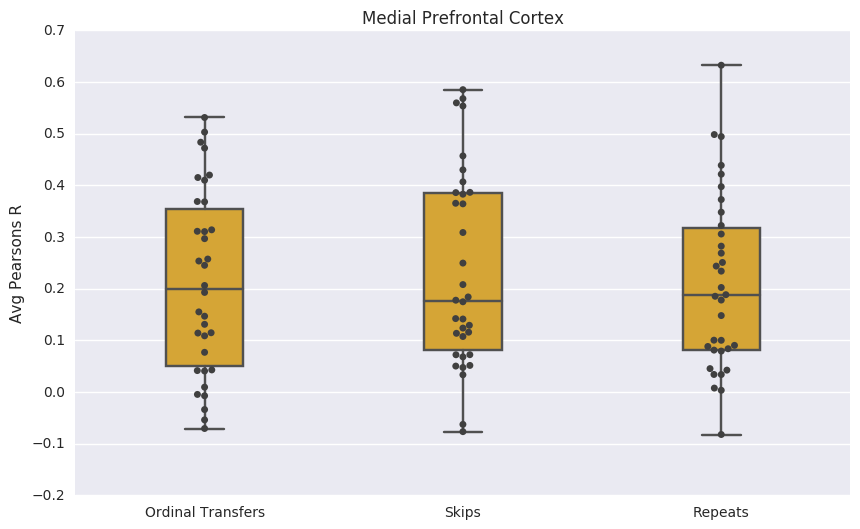

In [19]:
for key in mPFC_avg_df:
    print "Mean {0}: ".format(key), np.mean(mPFC_avg_df['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(mPFC_avg_df['{0}'.format(key)])
    print "Shapiro's Test of Normality:", stats.shapiro(mPFC_avg_df['{0}'.format(key)])
    print "--------"    
N = 3
conditions = ['Ordinal Transfers', 'Skips', 'Repeats']
mpfc_allsubjs = [mPFC_avg_df['ots'], mPFC_avg_df['skips'], mPFC_avg_df['repeats']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,6))
ax0 = sns.boxplot(data = mpfc_allsubjs, color = "#efb01c", width = 0.3)
ax2 = sns.swarmplot(data = mpfc_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Avg Pearsons R")
ax.set_title("Medial Prefrontal Cortex")
plt.show()

### Ordinal Transfers

Mean pos4:  0.324039
STD pos4:  0.230736
Shapiro's Test of Normality: (0.9658752679824829, 0.3574935495853424)
--------
Mean pos5:  0.174233
STD pos5:  0.20432
Shapiro's Test of Normality: (0.983148455619812, 0.8654373288154602)
--------
Mean pos2:  0.148659
STD pos2:  0.19357
Shapiro's Test of Normality: (0.9707054495811462, 0.4811990261077881)
--------
Mean pos3:  0.159586
STD pos3:  0.220896
Shapiro's Test of Normality: (0.958885133266449, 0.22558461129665375)
--------


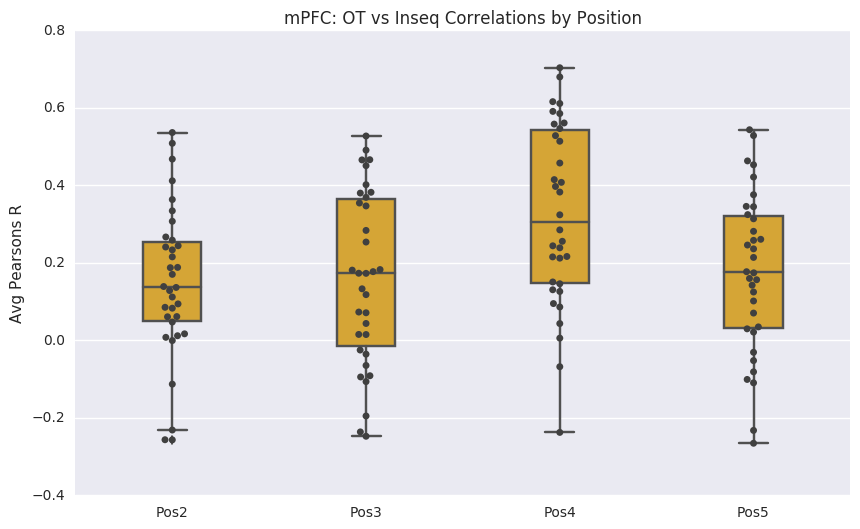

In [20]:
ot_mpfc_corrs = {'pos2':[], 'pos3':[], 'pos4':[], 'pos5':[]}

for i, sub in enumerate(sids):
    for x in ['2','3','4','5']:
        mpfc_corr = eval('stats.pearsonr(ot_df["mpfc_pos{0}"][{1}],inseq_df["mpfc_pos{0}"][{1}])[0]'.format(x,i))
        ot_mpfc_corrs["pos{0}".format(x)].append(mpfc_corr)
ot_mpfc_corrs_df = pd.DataFrame(ot_mpfc_corrs)
corr_table = []
for key in ot_mpfc_corrs:
    print "Mean {0}: ".format(key), np.mean(ot_mpfc_corrs['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(ot_mpfc_corrs['{0}'.format(key)])
    print "Shapiro's Test of Normality:", stats.shapiro(ot_mpfc_corrs['{0}'.format(key)])
    print "--------"
N = 4
conditions = ['Pos2', 'Pos3', 'Pos4', 'Pos5']
mpfc_allsubjs = [ot_mpfc_corrs['pos2'], ot_mpfc_corrs['pos3'], 
                 ot_mpfc_corrs['pos4'], ot_mpfc_corrs['pos5']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,6))
ax0 = sns.boxplot(data = mpfc_allsubjs, color = "#efb01c", width = 0.3)
ax2 = sns.swarmplot(data = mpfc_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Avg Pearsons R")
ax.set_title("mPFC: OT vs Inseq Correlations by Position")
plt.show()

### Skips

Mean pos4:  0.317981
STD pos4:  0.215766
Shapiro's Test of Normality: (0.9604130983352661, 0.24997952580451965)
--------
Mean pos5:  0.108478
STD pos5:  0.121201
Shapiro's Test of Normality: (0.96323162317276, 0.30130642652511597)
--------
Mean pos2:  0.170137
STD pos2:  0.200704
Shapiro's Test of Normality: (0.9563408493995667, 0.1898142695426941)
--------
Mean pos3:  0.206429
STD pos3:  0.216848
Shapiro's Test of Normality: (0.9853688478469849, 0.9191669225692749)
--------


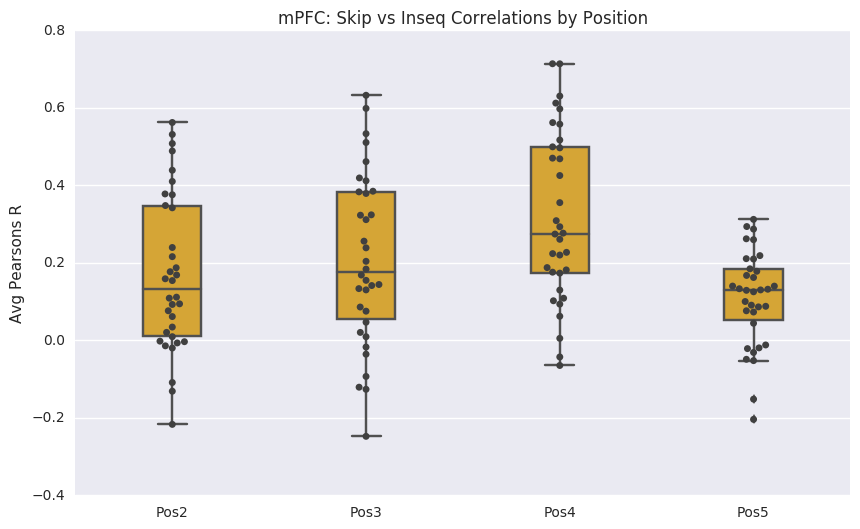

In [21]:
skip_mpfc_corrs = {'pos2':[], 'pos3':[], 'pos4':[], 'pos5':[]}

for i, sub in enumerate(sids):
    for x in ['2','3','4','5']:
        mpfc_corr=eval('stats.pearsonr(skip_df["mpfc_pos{0}"][{1}],inseq_df["mpfc_pos{0}"][{1}])[0]'.format(x,i))
        skip_mpfc_corrs["pos{0}".format(x)].append(mpfc_corr)
skip_mpfc_corrs_df = pd.DataFrame(skip_mpfc_corrs)
corr_table = []
for key in skip_mpfc_corrs:
    print "Mean {0}: ".format(key), np.mean(skip_mpfc_corrs['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(skip_mpfc_corrs['{0}'.format(key)])
    print "Shapiro's Test of Normality:", stats.shapiro(skip_mpfc_corrs['{0}'.format(key)])
    print "--------"
N = 4
conditions = ['Pos2', 'Pos3', 'Pos4', 'Pos5']
mpfc_skip_allsubjs = [skip_mpfc_corrs['pos2'], skip_mpfc_corrs['pos3'], 
                    skip_mpfc_corrs['pos4'], skip_mpfc_corrs['pos5']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,6))
ax0 = sns.boxplot(data = mpfc_skip_allsubjs, color = "#efb01c", width = 0.3)
ax2 = sns.swarmplot(data = mpfc_skip_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Avg Pearsons R")
ax.set_title("mPFC: Skip vs Inseq Correlations by Position")
plt.show()

### Repeats

Mean pos6:  0.133719
STD pos6:  0.213979
Shapiro's Test of Normality: (0.9595808982849121, 0.23640835285186768)
--------
Mean pos4:  0.278548
STD pos4:  0.231204
Shapiro's Test of Normality: (0.9673217535018921, 0.3916911482810974)
--------
Mean pos5:  0.182481
STD pos5:  0.194868
Shapiro's Test of Normality: (0.9344983696937561, 0.04236524552106857)
--------
Mean pos3:  0.166811
STD pos3:  0.168563
Shapiro's Test of Normality: (0.9737547636032104, 0.5721663236618042)
--------


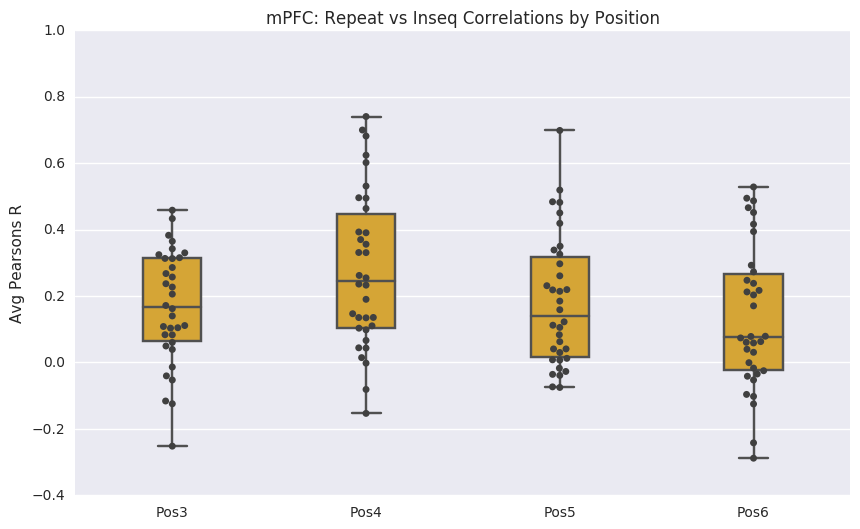

In [24]:
repeat_mpfc_corrs = {'pos3':[], 'pos4':[], 'pos5':[], 'pos6':[]}

for i, sub in enumerate(sids):
    for x in ['3','4','5','6']:
        mpfc_corr=eval('stats.pearsonr(repeat_df["mpfc_pos{0}"][{1}],inseq_df["mpfc_pos{0}"][{1}])[0]'.format(x,i))
        repeat_mpfc_corrs["pos{0}".format(x)].append(mpfc_corr)
repeat_mpfc_corrs_df = pd.DataFrame(repeat_mpfc_corrs)
corr_table = []
for key in repeat_mpfc_corrs:
    print "Mean {0}: ".format(key), np.mean(repeat_mpfc_corrs['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(repeat_mpfc_corrs['{0}'.format(key)])
    print "Shapiro's Test of Normality:", stats.shapiro(repeat_mpfc_corrs['{0}'.format(key)])
    print "--------"
N = 4
conditions = ['Pos3', 'Pos4', 'Pos5', 'Pos6']
mpfc_repeat_allsubjs = [repeat_mpfc_corrs['pos3'], repeat_mpfc_corrs['pos4'], 
                       repeat_mpfc_corrs['pos5'], repeat_mpfc_corrs['pos6']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (10,6))
ax0 = sns.boxplot(data = mpfc_repeat_allsubjs, color = "#efb01c", width = 0.3)
ax2 = sns.swarmplot(data = mpfc_repeat_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Avg Pearsons R")
ax.set_title("mPFC: Repeat vs Inseq Correlations by Position")
plt.show()

#sns.heatmap(corr_table, annot=True)